In [109]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import joblib 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif , chi2
from sklearn.preprocessing import StandardScaler , OneHotEncoder , OrdinalEncoder
from sklearn.metrics import f1_score , classification_report , confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import xgboost as xgb



In [110]:
DATA_PATH = os.path.join(os.getcwd(),'..','dataset','Churn_Modelling.csv')
df = pd.read_csv(DATA_PATH)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [111]:
df = df.drop(columns=['RowNumber','CustomerId','Surname'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


#EDA

In [112]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [113]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [114]:
df['Exited'].value_counts(normalize=True)

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

* Data visualization & handling outliers

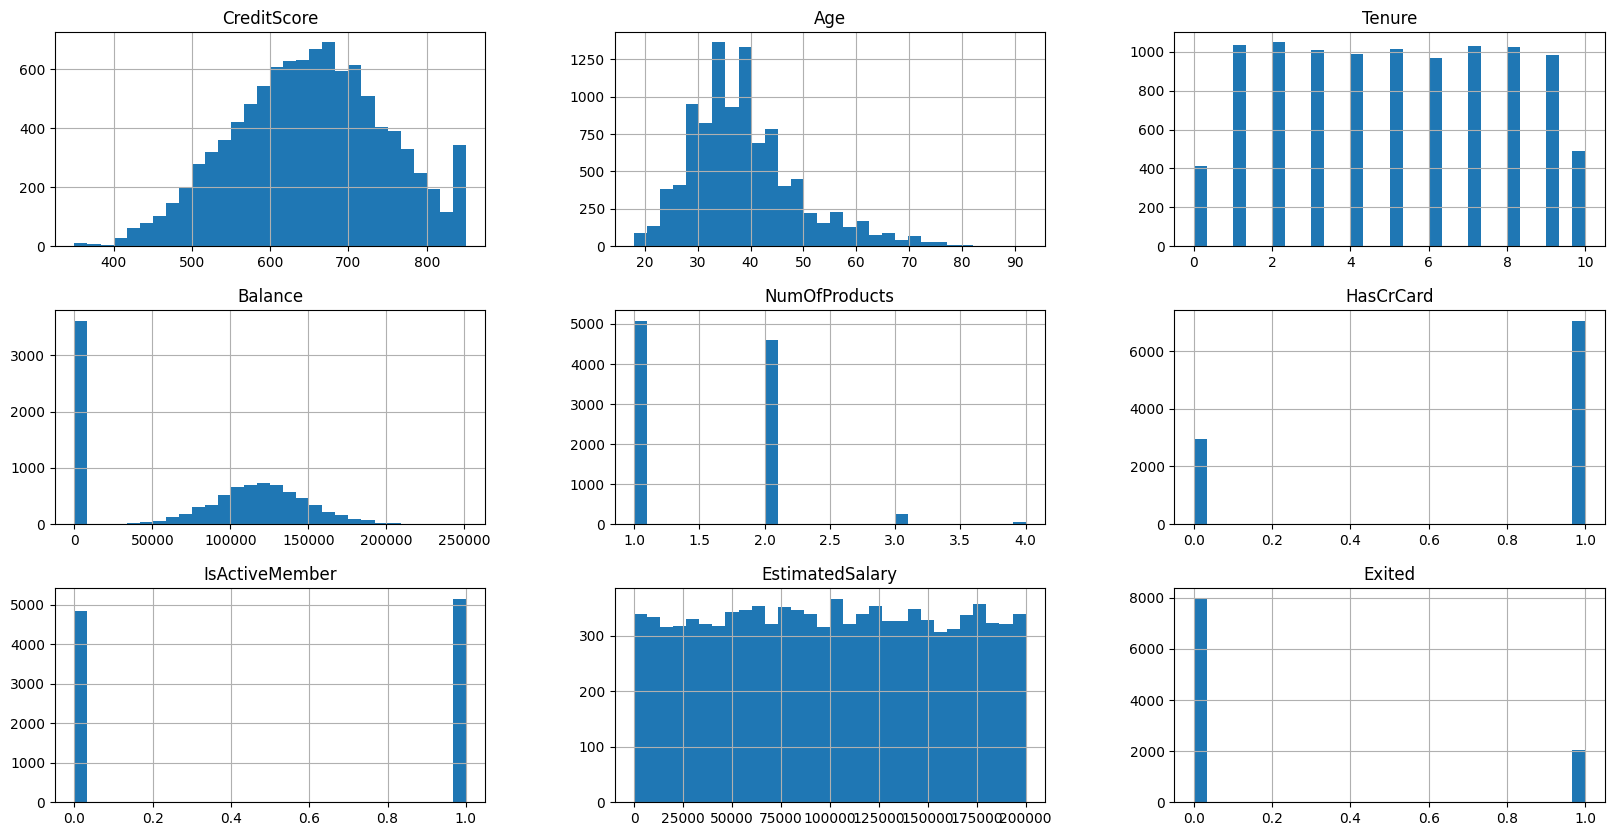

In [115]:
df.hist(bins = 30 , figsize=(20,10))
plt.show()

In [116]:
df[df['Age'] >= 80]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
310,652,France,Female,80,4,0.00,2,1,1,188603.07,0
766,700,France,Female,82,2,0.00,2,0,1,182055.36,0
2458,513,Spain,Male,88,10,0.00,2,1,1,52952.24,0
3033,787,France,Female,85,10,0.00,2,1,1,116537.96,0
3387,537,Germany,Male,84,8,92242.34,1,1,1,186235.98,0
3531,408,France,Female,84,8,87873.39,1,0,0,188484.52,1
3994,809,Spain,Male,80,8,0.00,2,0,1,34164.05,0
4931,682,Germany,Male,81,6,122029.15,1,1,1,50783.88,0
6443,753,France,Male,92,3,121513.31,1,0,1,195563.99,0
6759,705,France,Male,92,1,126076.24,2,1,1,34436.83,0


In [117]:
df = df.drop(index=df[df['Age']>=80].index)

In [118]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


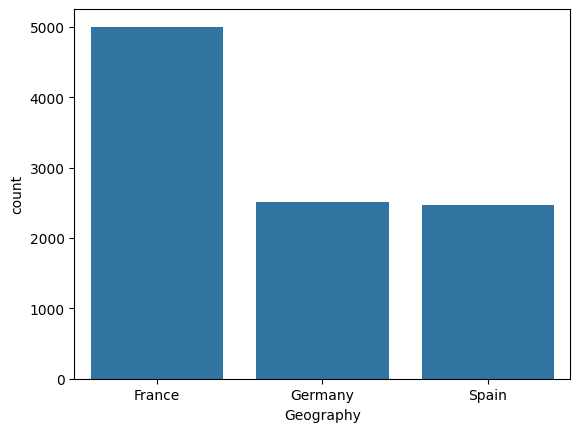

In [119]:
sns.countplot(data=df,x='Geography',order=df['Geography'].value_counts().index.to_list())
plt.show()

<Axes: xlabel='Gender', ylabel='EstimatedSalary'>

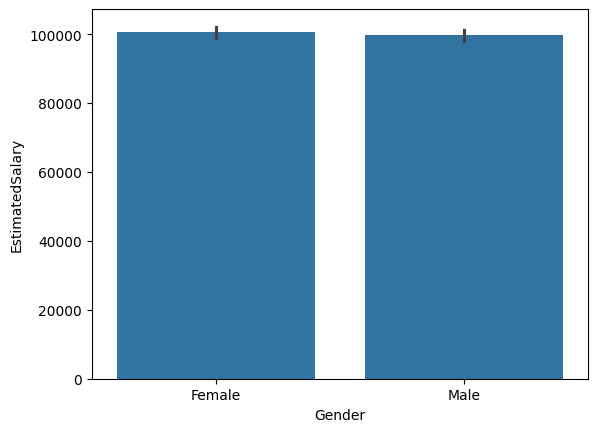

In [120]:
sns.barplot(data = df , x='Gender',y='EstimatedSalary')

In [121]:
df[['Gender','EstimatedSalary']].groupby('Gender')['EstimatedSalary'].mean()

Gender
Female    100556.596233
Male       99690.142441
Name: EstimatedSalary, dtype: float64

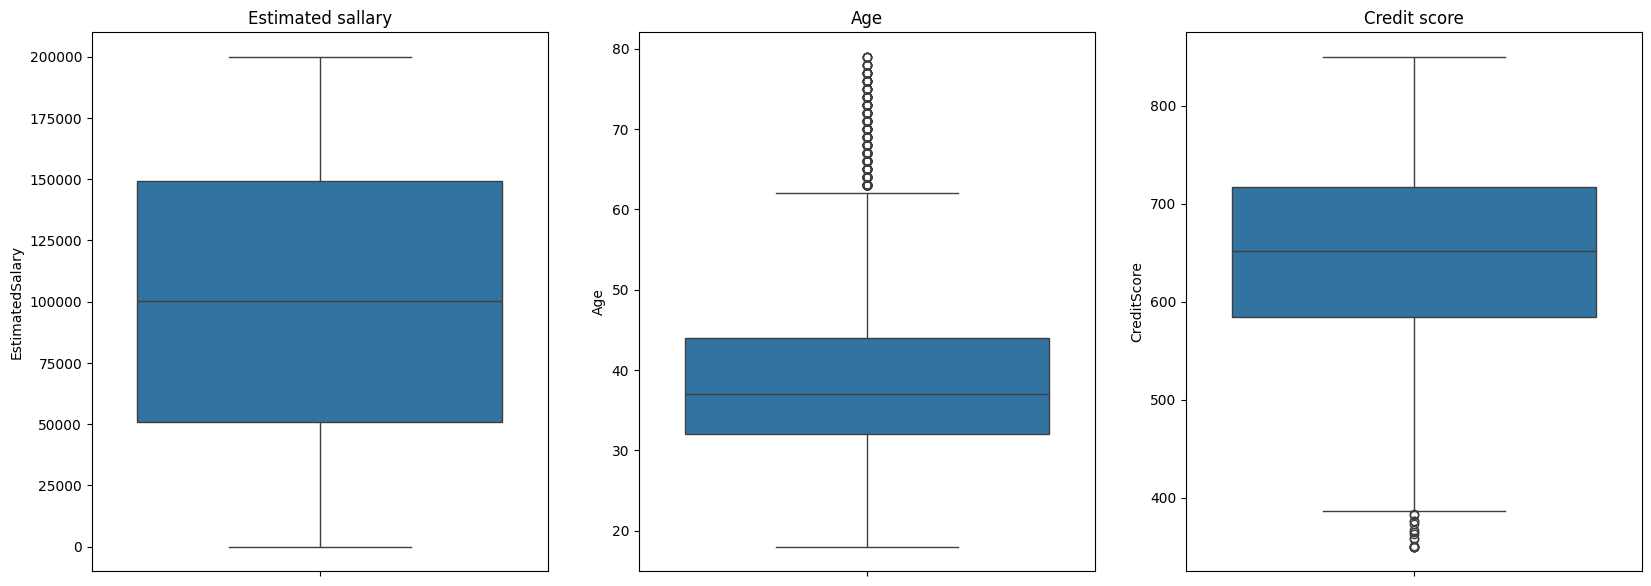

In [122]:
fig , axs = plt.subplots(1,3,figsize=(20,7))

# Estimated sallary outliers
plt.sca(axs[0])
sns.boxplot(data=df , y='EstimatedSalary')
plt.title('Estimated sallary')


# Age outliers
plt.sca(axs[1])
sns.boxplot(data=df , y='Age')
plt.title('Age')

#Credit score outliers
plt.sca(axs[2])
sns.boxplot(data=df , y='CreditScore')
plt.title('Credit score')


plt.show()

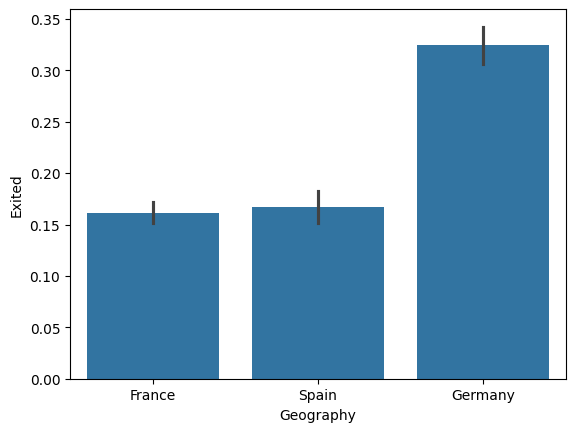

In [123]:
sns.barplot(data = df , x= 'Geography' ,y='Exited')
plt.show()

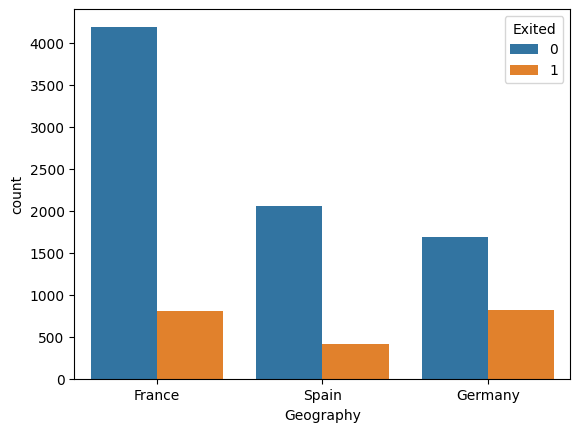

In [124]:
sns.countplot(data=df,x='Geography',hue='Exited')  ## labels, titles
plt.show()

In [125]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [126]:
num_features = ['CreditScore','Age','Balance','EstimatedSalary']
cat_features = ['Gender','Geography']
target_feature = ['Exited']
ready_features = list(set(df.columns.to_list())-set(num_features)-set(cat_features)-set(target_feature))
ready_features

['Tenure', 'NumOfProducts', 'IsActiveMember', 'HasCrCard']

In [127]:
df['Tenure'].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0])

In [128]:
# data split
X= df.drop(columns=['Exited'])
y = df['Exited']

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42 , stratify=y)
print(type(y))

<class 'pandas.core.series.Series'>


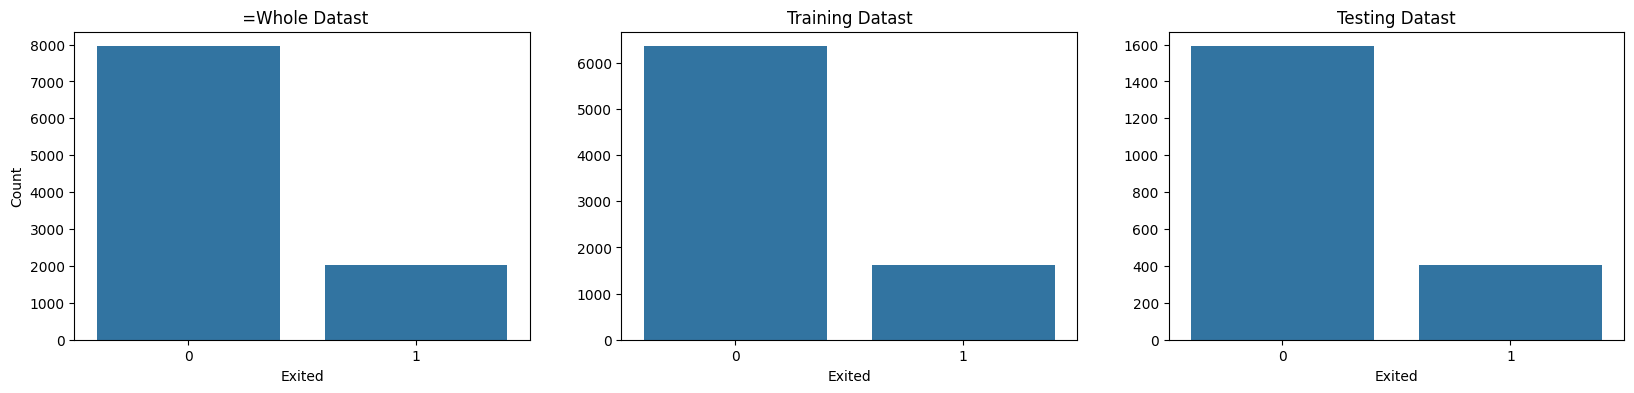

In [129]:
# plottting to check
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

# Whole dataset
plt.sca(ax[0])
sns.countplot(x=y)
plt.title(' =Whole Datast')
plt.ylabel('Count')

# train
plt.sca(ax[1])
sns.countplot(x=y_train)
plt.title('Training Datast')
plt.ylabel('')

# test
plt.sca(ax[2])
sns.countplot(x=y_test)
plt.title('Testing Datast')
plt.ylabel('')
plt.show()

In [130]:
# p values for numerical features
_,p_values = f_classif(X=X_train[num_features],y=y_train)
print(p_values)

[1.00799361e-002 8.06719607e-152 9.52107506e-031 3.20639168e-001]


In [131]:
# p values for cat features 
_,p_values = chi2(X=OrdinalEncoder().fit_transform(X_train[cat_features]),y=y_train)
p_values

array([2.04438781e-10, 2.53500461e-03])

In [132]:
_,p_values = chi2(X=X_train[ready_features],y= y_train)
p_values

array([6.26154520e-01, 2.47077798e-02, 1.33343129e-22, 6.87536041e-01])

In [136]:
# Pipeline : 
num_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaling',StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoding',OneHotEncoder(sparse_output=False,drop='first'))

])

ready_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
])
#
preprocessing = ColumnTransformer([
    ('numerical',num_pipeline,num_features),
    ('categorical',cat_pipeline,cat_features),
    ('ready',ready_pipeline,ready_features)
])


X_train_processed = preprocessing.fit_transform(X_train)
X_test_preprocessed = preprocessing.transform(X_test)



In [137]:
X_train_processed.shape , y_train.shape

((7988, 11), (7988,))

In [140]:
X_test_preprocessed.shape,y_test.shape

((1997, 11), (1997,))

In [144]:
preprocessing.get_feature_names_out()

array(['numerical__CreditScore', 'numerical__Age', 'numerical__Balance',
       'numerical__EstimatedSalary', 'categorical__Gender_Male',
       'categorical__Geography_Germany', 'categorical__Geography_Spain',
       'ready__Tenure', 'ready__NumOfProducts', 'ready__IsActiveMember',
       'ready__HasCrCard'], dtype=object)